# Quantum Anharmonic Oscillator

In [2]:
# Cell 1: Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import time


In [3]:
# Cell 2: Moment calculation function
def compute_moments(E, x2, g, max_t):
    """Compute moments <x^t> using recursion relation from eq. (6)"""
    moments = np.zeros(max_t + 1)
    moments[0] = 1.0  # Normalization
    moments[2] = x2   # Given parameter
    
    # Odd moments are zero
    for t in range(1, max_t + 1, 2):
        moments[t] = 0.0
    
    # Energy relation: E = 2<x^2> + 3g<x^4>
    if max_t >= 4:
        moments[4] = (E - 2*moments[2]) / (3*g)
        if moments[4] < 0 or not np.isfinite(moments[4]):
            return None
    
    # Recursion for even moments using odd t values
    for t in range(1, max_t - 2, 2):  # t = 1,3,5,...
        target = t + 3
        if target > max_t:
            break
            
        numerator = 4*t*E*moments[t-1]
        if t-3 >= 0:
            numerator += t*(t-1)*(t-2)*moments[t-3]
        if t+1 <= max_t:
            numerator -= 4*(t+1)*moments[t+1]
            
        denominator = 4*g*(t + 2)
        
        if abs(denominator) < 1e-12:
            return None
            
        moments[target] = numerator / denominator
        if not np.isfinite(moments[target]):
            return None
    
    return moments

# Test with known values from paper (E=1.392, <x²>=0.302)
test_moments = compute_moments(1.392, 0.302, 1.0, 10)
assert test_moments is not None, "Moment calculation failed"
print("✓ compute_moments passed basic test")
print("⟨x⁴⟩ =", test_moments[4])


✓ compute_moments passed basic test
⟨x⁴⟩ = 0.26266666666666666


In [4]:
# Cell 3: Bootstrap matrix construction
def build_bootstrap_matrix(moments, K):
    """Construct M_ij = <x^{i+j}> matrix"""
    if moments is None:
        return None
    
    M = np.zeros((K+1, K+1))
    for i in range(K+1):
        for j in range(K+1):
            power = i + j
            if power < len(moments):
                M[i,j] = moments[power]
            else:
                return None  # Insufficient moments
    return M

# Test matrix construction
test_matrix = build_bootstrap_matrix(test_moments, 3)
assert test_matrix.shape == (4,4), "Matrix shape incorrect"
print("✓ build_bootstrap_matrix passed basic test")
print("M[0,2] =", test_matrix[0,2])


✓ build_bootstrap_matrix passed basic test
M[0,2] = 0.302


In [5]:
# Cell 4: Positive semidefinite check
def is_positive_semidefinite(M, tol=1e-8):
    """Check if matrix is PSD using eigenvalues"""
    if M is None:
        return False
    try:
        eigvals = eigh(M, eigvals_only=True)
        return np.all(eigvals >= -tol)
    except:
        return False

# Test PSD check
test_psd = is_positive_semidefinite(np.eye(3))
assert test_psd, "PSD check failed on identity matrix"
print("✓ is_positive_semidefinite passed basic test")


✓ is_positive_semidefinite passed basic test


In [17]:
# Cell 5: Parameter configuration
g = 1.0
K_values = [7, 8, 9, 10, 11]
E_range = np.linspace(4.5, 4.7, 500)
x2_range = np.linspace(0.794, 0.808, 500)
max_t = 2 * max(K_values) + 6  # 2*11 + 6 = 28

print("Parameters configured:")
print(f"Energy range: {E_range[0]:.3f} to {E_range[-1]:.3f}")
print(f"⟨x²⟩ range: {x2_range[0]:.3f} to {x2_range[-1]:.3f}")
print(f"Max moment calculated: ⟨x^{max_t}⟩")


Parameters configured:
Energy range: 4.500 to 4.700
⟨x²⟩ range: 0.794 to 0.808
Max moment calculated: ⟨x^28⟩


In [18]:
# Cell 6: Main scanning loop
valid_points = {K: [] for K in K_values}
start_time = time.time()

total = len(E_range) * len(x2_range)
count = 0

for E in E_range:
    for x2 in x2_range:
        count += 1
        if count % 10000 == 0:
            print(f"Progress: {count}/{total} ({count/total:.1%})")
        
        # Basic physical checks
        if E < 2*x2 or (E - 2*x2)/(3*g) < 0:
            continue
            
        # Compute moments
        moments = compute_moments(E, x2, g, max_t)
        if moments is None:
            continue
            
        # Test bootstrap constraints
        for K in K_values:
            M = build_bootstrap_matrix(moments, K)
            if M is not None and is_positive_semidefinite(M):
                valid_points[K].append((E, x2))

print(f"\nCompleted in {time.time()-start_time:.1f} seconds")


Progress: 10000/250000 (4.0%)
Progress: 20000/250000 (8.0%)
Progress: 30000/250000 (12.0%)
Progress: 40000/250000 (16.0%)
Progress: 50000/250000 (20.0%)
Progress: 60000/250000 (24.0%)
Progress: 70000/250000 (28.0%)
Progress: 80000/250000 (32.0%)
Progress: 90000/250000 (36.0%)
Progress: 100000/250000 (40.0%)
Progress: 110000/250000 (44.0%)
Progress: 120000/250000 (48.0%)
Progress: 130000/250000 (52.0%)
Progress: 140000/250000 (56.0%)
Progress: 150000/250000 (60.0%)
Progress: 160000/250000 (64.0%)
Progress: 170000/250000 (68.0%)
Progress: 180000/250000 (72.0%)
Progress: 190000/250000 (76.0%)
Progress: 200000/250000 (80.0%)
Progress: 210000/250000 (84.0%)
Progress: 220000/250000 (88.0%)
Progress: 230000/250000 (92.0%)
Progress: 240000/250000 (96.0%)
Progress: 250000/250000 (100.0%)

Completed in 62.1 seconds


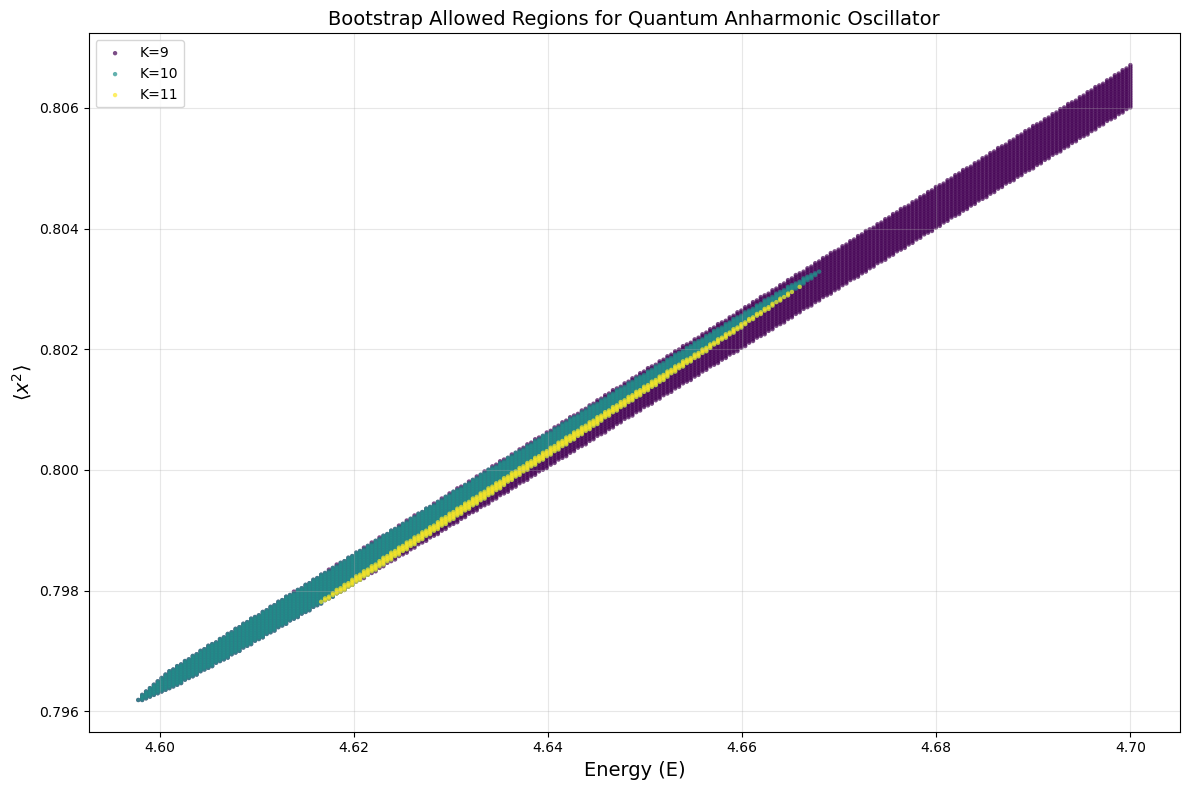

In [19]:
# Cell 7: Visualization
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(K_values)))

for i, K in enumerate(K_values):
    if valid_points[K]:
        data = np.array(valid_points[K])
        plt.scatter(data[:,0], data[:,1], s=10, color=colors[i],
                   label=f'K={K}', alpha=0.7, edgecolors='none')

plt.xlabel('Energy (E)', fontsize=14)
plt.ylabel(r'$\langle x^2 \rangle$', fontsize=14)
plt.title('Bootstrap Allowed Regions for Quantum Anharmonic Oscillator', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


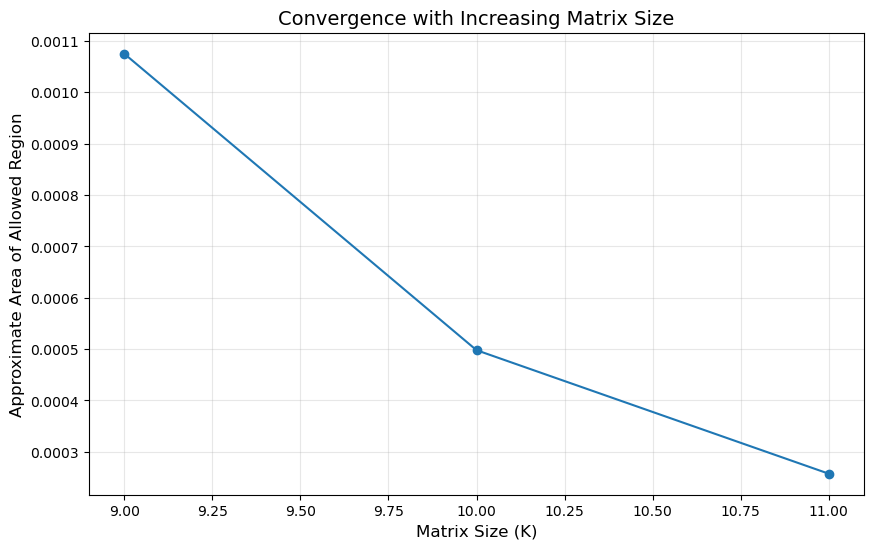

In [20]:
# Cell 8 (Optional): Convergence analysis
if len(K_values) > 1:
    plt.figure(figsize=(10, 6))
    
    # Calculate areas of allowed regions
    areas = {}
    for K in K_values:
        if valid_points[K]:
            data = np.array(valid_points[K])
            x = data[:,0]
            y = data[:,1]
            areas[K] = (x.max()-x.min())*(y.max()-y.min())
    
    plt.plot(K_values, [areas.get(K, 0) for K in K_values], 'o-')
    plt.xlabel('Matrix Size (K)', fontsize=12)
    plt.ylabel('Approximate Area of Allowed Region', fontsize=12)
    plt.title('Convergence with Increasing Matrix Size', fontsize=14)
    plt.grid(alpha=0.3)
    plt.show()


# One Matrix Quantum Mechanics

In [1]:
# Cell 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import cvxpy as cp
from scipy.optimize import minimize_scalar

print("✓ Libraries imported")

✓ Libraries imported


NameError: name 'abc' is not defined